In [52]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [65]:
# Define file paths
input_path = "datasets"
print("Files in dataset directory:")
print(os.listdir(input_path))

features_cols = [
    "ImageData.c1c6.summary.bathroom",
    "ImageData.q1q6.summary.bathroom",
    "ImageData.c1c6.summary.kitchen",
    "ImageData.q1q6.summary.kitchen",
    "ImageData.c1c6.summary.exterior",
    "ImageData.q1q6.summary.exterior",
    "ImageData.c1c6.summary.interior",
    "ImageData.q1q6.summary.interior",
    "ImageData.c1c6.summary.property",
    "ImageData.q1q6.summary.property",
    "ImageData.style.stories.summary.label",
    # "ImageData.room_type_reso.results",
    "Characteristics.LotSizeSquareFeet",
    "Location.Address.PostalCodePlus4",
    "Property.PropertyType",
    "Structure.BathroomsFull",
    "Structure.BedroomsTotal",
    "Structure.BathroomsHalf",
    "Structure.Cooling",
    "Structure.FireplacesTotal",
    "Structure.LivingArea",
    "Structure.YearBuilt",
    "Structure.GarageSpaces",
    "Structure.Heating",
    "Structure.NewConstructionYN",
    "Location.GIS.Latitude",
    "Location.GIS.Longitude"
]
target_col = "Listing.Price.ClosePrice"
id_col = "Listing.ListingId"


# Load datasets
data = pd.read_csv(f"{input_path}/train.csv", usecols=features_cols + [target_col] + [id_col])
test_data = pd.read_csv(f"{input_path}/test.csv", usecols=features_cols + [id_col])

# Display dataset informations
print(f"Training data info: {data.info()}")
print(f"Test data info: {test_data.info()}")
print(data.info(memory_usage="deep"))

Files in dataset directory:
['train.csv', 'test.csv', 'description.pdf']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107437 entries, 0 to 107436
Data columns (total 28 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Characteristics.LotSizeSquareFeet      1690 non-null    float64
 1   ImageData.c1c6.summary.bathroom        90744 non-null   float64
 2   ImageData.c1c6.summary.exterior        87789 non-null   float64
 3   ImageData.c1c6.summary.interior        93597 non-null   float64
 4   ImageData.c1c6.summary.kitchen         92320 non-null   float64
 5   ImageData.c1c6.summary.property        103055 non-null  float64
 6   ImageData.q1q6.summary.bathroom        90708 non-null   float64
 7   ImageData.q1q6.summary.exterior        82565 non-null   float64
 8   ImageData.q1q6.summary.interior        93589 non-null   float64
 9   ImageData.q1q6.summary.kitchen         92292 non-nul

In [66]:
def reduce_df_size(df):
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].astype('float32')

reduce_df_size(data)
print(data.info(memory_usage="deep"))

reduce_df_size(test_data)
print(test_data.info(memory_usage="deep"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107437 entries, 0 to 107436
Data columns (total 28 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Characteristics.LotSizeSquareFeet      1690 non-null    float32
 1   ImageData.c1c6.summary.bathroom        90744 non-null   float32
 2   ImageData.c1c6.summary.exterior        87789 non-null   float32
 3   ImageData.c1c6.summary.interior        93597 non-null   float32
 4   ImageData.c1c6.summary.kitchen         92320 non-null   float32
 5   ImageData.c1c6.summary.property        103055 non-null  float32
 6   ImageData.q1q6.summary.bathroom        90708 non-null   float32
 7   ImageData.q1q6.summary.exterior        82565 non-null   float32
 8   ImageData.q1q6.summary.interior        93589 non-null   float32
 9   ImageData.q1q6.summary.kitchen         92292 non-null   float32
 10  ImageData.q1q6.summary.property        101798 non-null  

In [67]:
# Analyze missing data
missing_data = data.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_data / len(data)) * 100

# Display columns with missing values
print("Columns with missing values:")
print(missing_data[missing_data > 0])

# Drop columns with excessive missing values
columns_to_drop = ['Characteristics.LotSizeSquareFeet', 'Location.Address.PostalCodePlus4', 'Structure.FireplacesTotal']
data.drop(columns=columns_to_drop, inplace=True, errors="ignore")
test_data.drop(columns=columns_to_drop, inplace=True, errors="ignore")

# Separate numeric and categorical features for imputation
numeric_features = data.select_dtypes(include=['float32']).drop(columns=[target_col], errors='ignore').columns
categorical_features = data.select_dtypes(include=['object']).columns

# Impute missing values
numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

data[numeric_features] = numeric_imputer.fit_transform(data[numeric_features])
data[categorical_features] = categorical_imputer.fit_transform(data[categorical_features])
test_data[numeric_features] = numeric_imputer.transform(test_data[numeric_features])
test_data[categorical_features] = categorical_imputer.transform(test_data[categorical_features])

Columns with missing values:
Characteristics.LotSizeSquareFeet        105747
Location.Address.PostalCodePlus4         104166
Structure.FireplacesTotal                 56221
ImageData.q1q6.summary.exterior           24872
ImageData.style.stories.summary.label     24086
ImageData.c1c6.summary.exterior           19648
Structure.GarageSpaces                    18816
ImageData.q1q6.summary.bathroom           16729
ImageData.c1c6.summary.bathroom           16693
ImageData.q1q6.summary.kitchen            15145
ImageData.c1c6.summary.kitchen            15117
ImageData.q1q6.summary.interior           13848
ImageData.c1c6.summary.interior           13840
Structure.LivingArea                       7928
Structure.BathroomsHalf                    7388
Structure.BathroomsFull                    7374
Location.GIS.Longitude                     6997
Location.GIS.Latitude                      6997
Structure.Cooling                          5950
ImageData.q1q6.summary.property            5639
Structure.Y

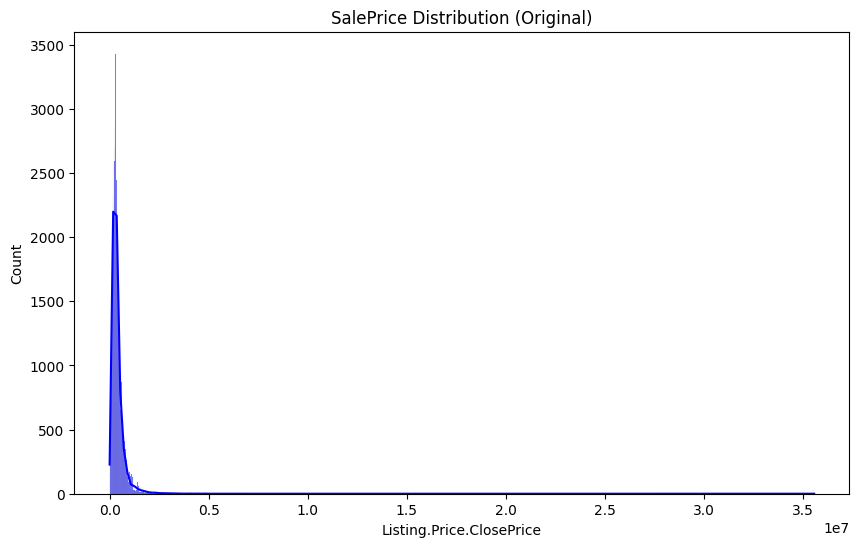

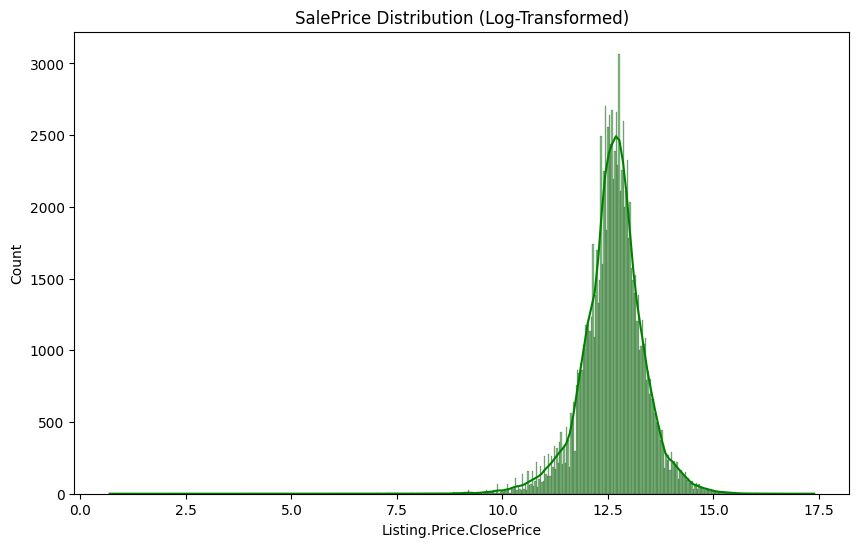

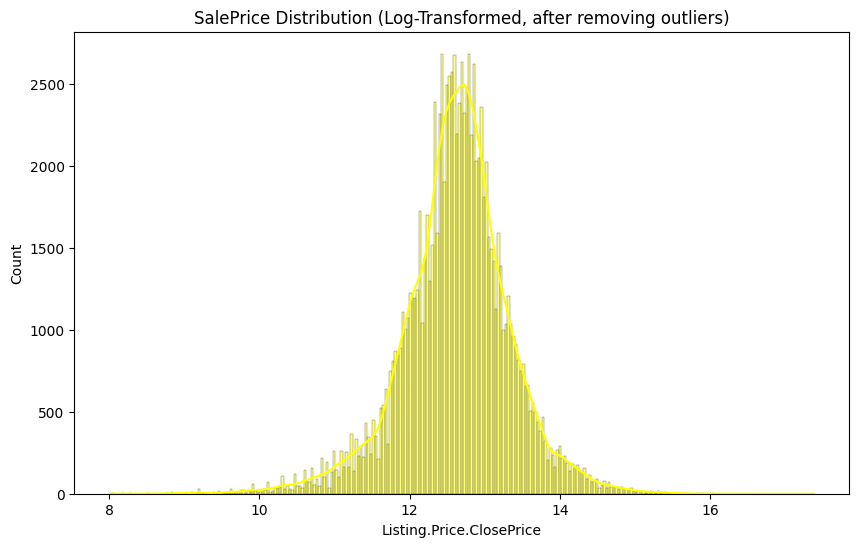

In [68]:
plt.figure(figsize=(10, 6))
sns.histplot(data[target_col], kde=True, color='blue')
plt.title("SalePrice Distribution (Original)")
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(data[target_col]), kde=True, color='green')
plt.title("SalePrice Distribution (Log-Transformed)")
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(data[np.log1p(data[target_col]) > 8][target_col]), kde=True, color='yellow')
plt.title("SalePrice Distribution (Log-Transformed, after removing outliers)")
plt.show()

In [69]:
# Remove outliers
data = data[np.log1p(data[target_col]) > 8]

# Log-transform target variable
y = np.log1p(data[target_col])

# Drop unnecessary columns
X = data.drop(columns=[target_col, id_col])
X_test = test_data.drop(columns=[id_col])

# Preprocessing pipeline
def preprocess_data(X, preprocessor=None, fit=True):
    numerical_features = X.select_dtypes(include=['float32']).columns
    categorical_features = X.select_dtypes(include=['category']).columns

    if preprocessor is None:
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)
            ]
        )

    if fit:
        X_transformed = preprocessor.fit_transform(X)
    else:
        X_transformed = preprocessor.transform(X)

    return X_transformed, preprocessor

# Preprocess data
X_transformed, preprocessor = preprocess_data(X, fit=True)
X_test_transformed, _ = preprocess_data(X_test, preprocessor=preprocessor, fit=False)

In [ ]:
# Split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Define models
models = {
    # 'Lasso': Lasso(alpha=0.01),
    # 'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5),
    # 'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'RandomForest100': RandomForestRegressor(n_estimators=100, random_state=42),
}
# Evaluate models using cross-validation
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
    results[name] = -scores.mean()

# Display RMSE results
results_df = pd.DataFrame(results.items(), columns=['Model', 'RMSE']).sort_values(by='RMSE')
results_df['RMSE'] = results_df['RMSE'].map("{:.5f}".format)
results_df

              Model     RMSE
2      RandomForest  0.31227
3  GradientBoosting  0.35838
1        ElasticNet  0.45685
0             Lasso  0.45887


In [78]:
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
# Make predictions on the test set
train_predictions = np.expm1(best_model.predict(X_transformed))

result = pd.DataFrame({
    # In the provided CSV the longitude and latitude are inverted
    "Location.GIS.Latitude": data["Location.GIS.Longitude"].astype(float),
    "Location.GIS.Logitude": data["Location.GIS.Latitude"].astype(float),
    id_col: data[id_col],
    "Listing.Price.ClosePriceActual": data[target_col],
    target_col: train_predictions
})

result.to_csv('result.csv', index=False)
print("Result file saved as 'result.csv'")

result[[id_col, target_col]].to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")


Result file saved as 'result.csv'
Submission file saved as 'submission.csv'


In [81]:
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
best_model.fit(X_transformed, y)
print(f"Selected Model: {best_model_name}")

Selected Model: RandomForest


In [ ]:
for name, model in models.items():
    # Make predictions on the test set
    test_predictions = np.expm1(model.predict(X_test_transformed))

    result = pd.DataFrame({
    # In the provided CSV the longitude and latitude are inverted
        "Location.GIS.Latitude": test_data["Location.GIS.Longitude"].astype(float),
        "Location.GIS.Logitude": test_data["Location.GIS.Latitude"].astype(float),
        id_col: test_data[id_col].astype(str),
        target_col: test_predictions.astype(float)
    })
    
    result_name = f"result_{name}.csv"
    result.to_csv(result_name, index=False)
    print(f"Result file saved as '{result_name}'")

    submission_name = "submission_{name}.csv"
    result[[id_col, target_col]].to_csv(submission_name, index=False)
    print(f"Submission file saved as '{submission_name}'")

In [83]:
test_predictions = np.expm1(best_model.predict(X_test_transformed))

result = pd.DataFrame({
    # In the provided CSV the longitude and latitude are inverted
    "Location.GIS.Latitude": test_data["Location.GIS.Longitude"].astype(float),
    "Location.GIS.Logitude": test_data["Location.GIS.Latitude"].astype(float),
    id_col: test_data[id_col],
    target_col: test_predictions
})

result.to_csv('result_test.csv', index=False)
print("Result file saved as 'result_test.csv'")

result[[id_col, target_col]].to_csv('submission_test.csv', index=False)
print("Submission file saved as 'submission_test.csv'")

Result file saved as 'result_test.csv'
Submission file saved as 'submission_test.csv'
